# Medical Image Analysis project - "Numerical Methods for Coupled Reconstruction and Registration in Digital Breast Tomosynthesis"

https://arxiv.org/pdf/1307.6008


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.ndimage

## Generation of a 3D full torus:
The carthesian equation of a 3D full torus of hole radius $c$ and tube radius $a$ is:
$$ (c - \sqrt(x^2 + y^2) )^2 + z^2 \leq a^2 $$

This can be stored in a 3D Numpy array.

In [2]:
# Discretization along axes
d = 71
x = np.linspace(-35, 35, d)
y = np.linspace(-35, 35, d)
z = np.linspace(-35, 35, d)

# Grid coordinates
xx, yy, zz = np.meshgrid(x, y, z, sparse=False)

# Torus definition
c, a = 16, 8
torus = ( (c - np.sqrt(xx**2 + yy**2))**2 + zz**2 - a**2 <= 0).transpose(0,2,1)

**Fixed image:**

In [3]:
f1 = np.copy(torus).astype(float)

Visualization:

In [4]:
def plot_volume(f, d=71):
    plt.figure(figsize=(12,4))
    plt.subplot("131")
    plt.title("Coronal view")
    plt.imshow(f[:,d//2,:], cmap='gray')
    plt.subplot("132")
    plt.title("Transverse view")
    plt.imshow(f[d//2,:,:], cmap='gray')
    plt.subplot("133")
    plt.title("Sagittal view")
    plt.imshow(f[:,:,d//2], cmap='gray')
    plt.show()

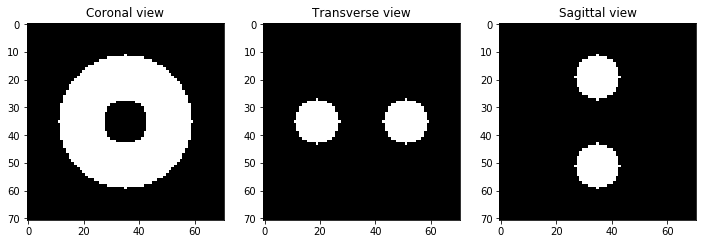

In [5]:
plot_volume(f1)

**Moving image:** result of an affine transformation.

In [6]:
def rotation_matrix(angle, axis='x'):
    if axis=='x':
        rot = np.array([[1, 0, 0],
                        [0, np.cos(angle), -np.sin(angle)],
                        [0, np.sin(angle), np.cos(angle)]])
    elif axis=='y':
        rot = np.array([[np.cos(angle), 0, -np.sin(angle)],
                        [0, 1, 0],
                        [np.sin(angle), 0, np.cos(angle)]])
    else:
        rot = np.array([[np.cos(angle), -np.sin(angle), 0],
                        [np.sin(angle), np.cos(angle), 0],
                        [0, 0, 1]])
    return rot


def affine_transformation(f, angle, translation, axis='x', order=3):
    
    # Rotation matrix
    rot = rotation_matrix(angle, axis)
        
    # Compute rotation center (center of volume)
    center = 0.5*np.array(f.shape)
    offset=-(center-center.dot(rot)).dot(np.linalg.inv(rot))

    # Compute transformation (along with interpolation)
    out = sp.ndimage.affine_transform(f,rot, offset=offset)
    # Binarize output
    #out[out>0.90] = 1.0
    #out[out<=0.90] = 0.0
    
    out = sp.ndimage.affine_transform(out, np.eye(3), offset=translation, order=order)
    
    return(out)

Construct moving image:

In [7]:
# Parameters
angle = (30/360)*2*np.pi
translation = np.array([0, -5, -10])

f2 = affine_transformation(f1, angle, translation, axis='x')

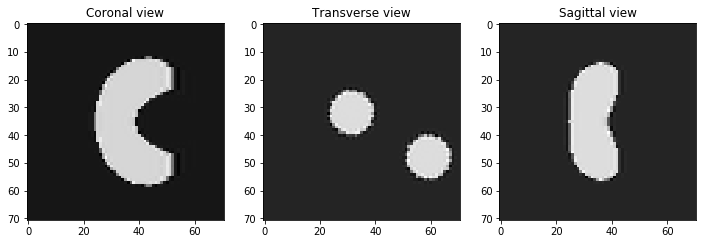

In [8]:
plot_volume(f2)

## Generate tomographic projections:

In [9]:
import tomopy as tp

/home/alex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Define projection angles:

In [10]:
angles = tp.sim.project.angles(11, ang1=-25.0, ang2=25.0)

Project $f_1$ and $f_2$ to get $p_1$ and $p_2$:

In [11]:
p1 = tp.sim.project.project(f1, angles, center=0.5*np.array(f1.shape), pad=False)
p2 = tp.sim.project.project(f2, angles, center=0.5*np.array(f2.shape), pad=False)

Visualization:

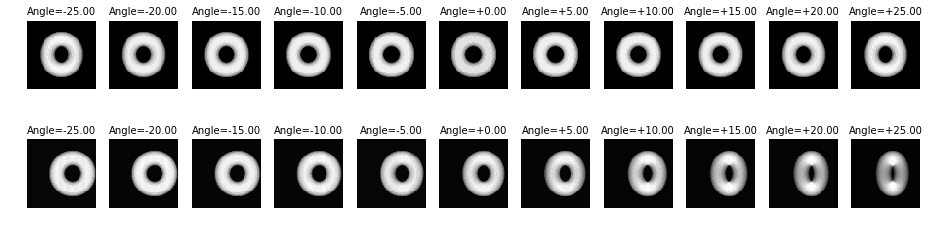

In [12]:
plt.figure(figsize=(16,4))
for i in range(11):
    plt.subplot(2, 11, i+1)
    plt.imshow(p1[i,:d,:d], cmap='gray')
    plt.title("Angle={:+.2f}".format(-25 + i*(50/10)), fontsize=10)
    plt.axis('off')
    plt.subplot(2, 11, i+12)
    plt.imshow(p2[i,:d,:d], cmap='gray')
    plt.title("Angle={:+.2f}".format(-25 + i*(50/10)), fontsize=10)
    plt.axis('off')

## Comparison of reconstruction methods:

### Conventional sequential method:
#### Reconstructions:

Definition of $A^T$ operator (returns a $d \times d \times d$ array):

In [13]:
def backward_projection(p):
    n, d = p.shape[0], p.shape[1]
    back = np.zeros((d, d, d))
    # Rotation center
    center = 0.5*np.array(back.shape)
    for i in range(n):
        # Compute expanded projection
        proj = np.expand_dims(p[i], axis=2)
        expanded_proj = np.tile(proj, d)
        # Compute associated rotation
        angle = -25 + i*(50/10)
        angle = (angle/360)*2*np.pi
        rot = rotation_matrix(angle, axis='x')
        offset=-(center-center.dot(rot)).dot(np.linalg.inv(rot))
        expanded_proj = sp.ndimage.affine_transform(expanded_proj, rot, offset=offset)
        back += (1/n) * expanded_proj
    return back

Rescale function to set reconstruction values between 0 and 1:

In [14]:
def rescale_array(f):
    min_f, max_f = np.min(f), np.max(f)
    return (f - min_f)/(max_f - min_f)

Gradient descent on the simple euclidean norm cost function:

In [21]:
def recon_grad_descent(p, stepsize=1e-2, tol=1e-2, max_iter=100,
                       angles=tp.sim.project.angles(11, ang1=-25.0, ang2=25.0),
                       init=None):
    # Parameters
    n, d = p.shape[0], p.shape[1]
    # Initialization
    if init is not None:
        f = init
    else:
        f = np.zeros((d,d,d))
    it = 0
    cost = []
    # Repeat until convergence
    while it<max_iter:
        proj = tp.sim.project.project(f, angles, center=0.5*np.array(f.shape), pad=False)
        criterion = np.linalg.norm( proj - p )
        cost.append(criterion)
        if criterion<tol:
            break
        else:
            f = f - stepsize * backward_projection( proj - p )
            it += 1
    
    return rescale_array(f), cost

Reconstruction of $f_1$ from $p_1$:

In [22]:
f1_rec, cost1 = recon_grad_descent(p1, stepsize=1e-3, tol=1e-2, max_iter=20)

In [23]:
f1_rec = rescale_array(f1_rec)

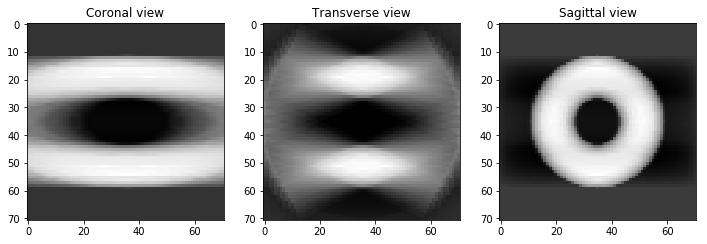

In [24]:
plot_volume(f1_rec)

Cost function against iterations:

Text(0.5,1,'||Af1_rec - p1||')

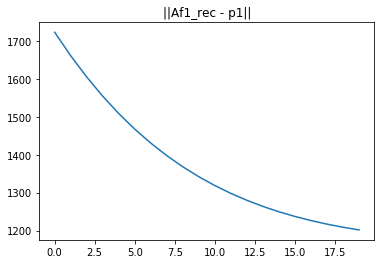

In [25]:
plt.plot(cost1)
plt.title('||Af1_rec - p1||')

Reconstruction of $f_2$ from $p_2$:

In [26]:
f2_rec, cost2 = recon_grad_descent(p2, stepsize=1e-3, tol=1e-2, max_iter=20)

In [27]:
f2_rec = rescale_array(f2_rec)

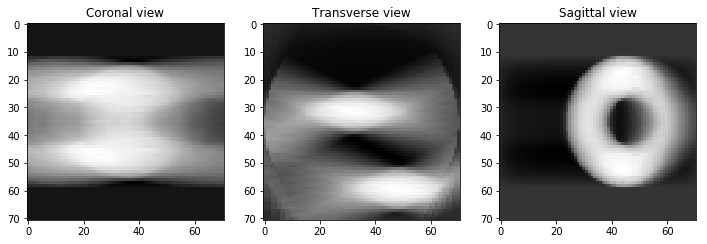

In [28]:
plot_volume(f2_rec)

Cost function against iterations:

Text(0.5,1,'||Af2_rec - p2||')

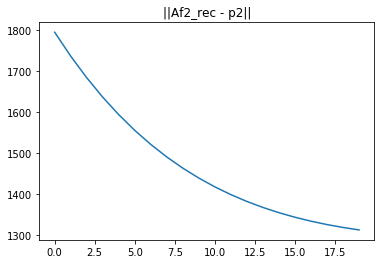

In [29]:
plt.plot(cost2)
plt.title('||Af2_rec - p2||')

#### Registration:

#### Sequential combination of reconstruction and registration:

Definition of a cost function (square of euclidean norm) and its gradient:

In [30]:
def cost_registration(f1, f2, angle, translation):
    return 0.5*np.linalg.norm(f2 - affine_transformation(f1, angle, translation, axis='x'))**2


def transformation_gradient(f1, f2, angle, translation, eps=1e-3):
    # Angle
    dcost_angle = (cost_registration(f1, f2, angle+eps, translation) - cost_registration(f1, f2, angle-eps, translation))/(2*eps)

    return dcost_angle

Gradient descent algorithm:

In [31]:
def registration_grad_descent(f1, f2, stepsize=1e-6, tol=1e-2, max_iter=100, init_angle=None):
    # Initialization
    if init_angle is not None:
        angle = init_angle
    else:
        np.random.seed(5)
        angle = np.random.normal(0, 1e-1) 
    it = 0
    cost = []
    # Find translation
    coord_f1 = np.array( np.where(f1 > 0.9) )
    coord_f2 = np.array( np.where(f2 > 0.5) )
    mean_1 = np.mean(coord_f1, axis=1)
    mean_2 = np.mean(coord_f2, axis=1)
    translation = mean_1 - mean_2
    # Repeat until convergence
    while it<max_iter:
        criterion = cost_registration(rescale_array(f1), rescale_array(f2), angle, translation)
        cost.append(criterion)       
        if criterion<tol:
            break
        else:
            grad = transformation_gradient(rescale_array(f1), rescale_array(f2), angle, translation, eps=1e-3)
            angle = angle - stepsize * grad
            angle = angle%(2*np.pi)
            it += 1
    
    return angle, translation, cost

Test on the original images:

In [32]:
angle_reg, translation_reg, cost = registration_grad_descent(f1, f2, max_iter=10, stepsize=5e-6)

In [33]:
print("Translation:", translation_reg)
print("Angle: {:+.2f}°".format(angle_reg/(2*np.pi)*360))

Translation: [  0.          -4.81036134 -10.29849317]
Angle: +29.85°


Text(0.5,1,'Registation coast ||T(f1) - f2||')

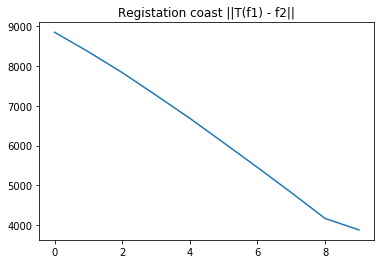

In [34]:
plt.plot(cost)
plt.title("Registation coast ||T(f1) - f2||")

Observation of difference between original moving imaged and guessed registered image:

In [35]:
f2_registered = affine_transformation(f1, angle=angle_reg, translation=translation_reg, axis='x')

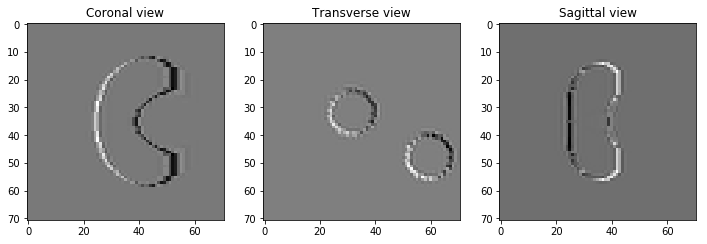

In [36]:
plot_volume(f2 - f2_registered)

Test on the reconstructed images:

In [37]:
angle_reg, translation_reg, cost = registration_grad_descent(f1_rec, f2_rec, max_iter=5, stepsize=5e-6)

In [38]:
print("Translation:", translation_reg)
print("Angle: {:+.2f}°".format(angle_reg/(2*np.pi)*360))

Translation: [ 0.         -9.77069076  0.35152401]
Angle: +0.19°


Text(0.5,1,'Registation coast ||T(f1) - f2||')

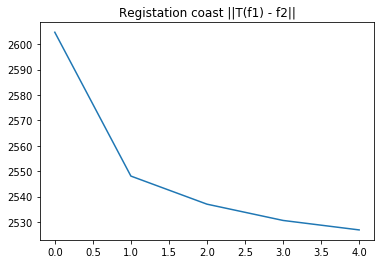

In [39]:
plt.plot(cost)
plt.title("Registation coast ||T(f1) - f2||")

Observation of difference between original moving imaged and guessed registered image:

In [40]:
f2_registered = affine_transformation(f1_rec, angle=angle_reg, translation=translation_reg, axis='x')

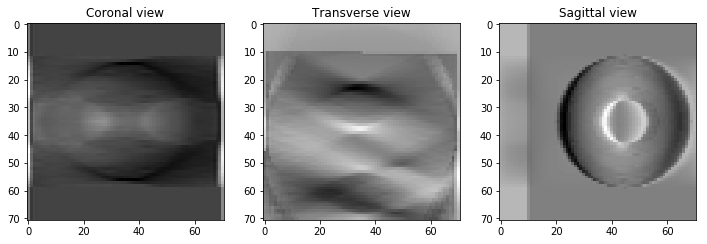

In [41]:
plot_volume(f2_rec - f2_registered)

### Iterative method:

In [42]:
def iterative_recon_reg(p1, p2, k=3, stepsize_recon=1e-3, iter_recon=3, stepsize_reg=1e-6):
    # Initialization
    n, d = p1.shape[0], p1.shape[1]
    f1, f2 = np.zeros((d,d,d)), np.zeros((d,d,d))
    angle = np.random.normal(0, 1e-1)
    
    for i in range(k):
        # j steps of reconstruction (j = iter_recon)
        f1, _ = recon_grad_descent(p1, stepsize=stepsize_recon, max_iter=iter_recon,init=f1)
        f1 = rescale_array(f1)
        f2, _ = recon_grad_descent(p2, stepsize=stepsize_recon, max_iter=iter_recon,init=f2)
        f2 = rescale_array(f2)
        # registration step
        angle, translation, _ = registration_grad_descent(f1_rec, f2_rec, max_iter=5, stepsize=5e-6,
                                                          init_angle=angle)
        # change f2 for its registered version
        f2 = affine_transformation(f1, angle=angle, translation=translation, axis='x')
        f2 = rescale_array(f2)
        
    return f1, f2, angle, translation

In [43]:
f1_rec_iter, f2_rec_iter, angle_iter, translation_iter = iterative_recon_reg(p1, p2,
                                                                             k=4, stepsize_recon=1e-4,
                                                                             iter_recon=4, stepsize_reg=1e-7)

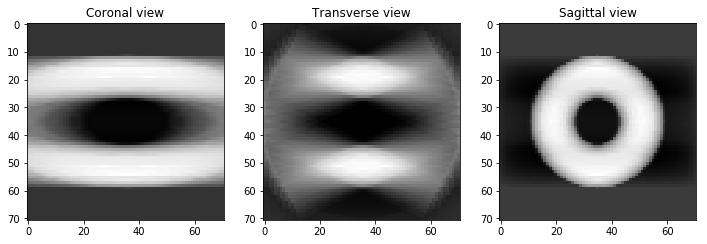

In [46]:
plot_volume(f1_rec)

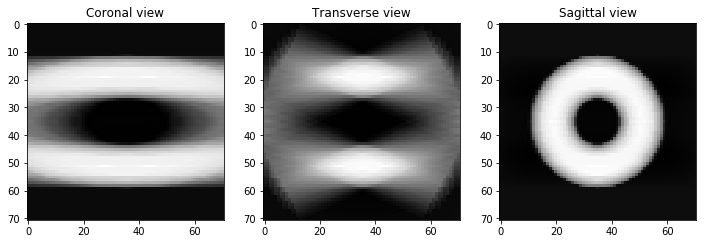

In [47]:
plot_volume(f1_rec_iter)

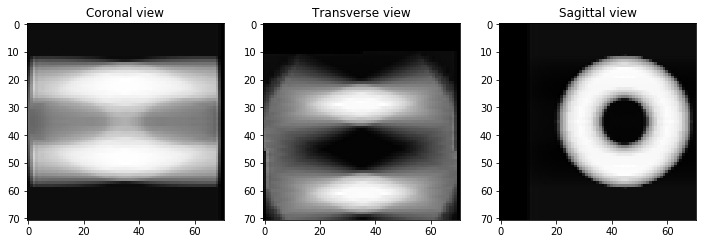

In [48]:
plot_volume(f2_rec_iter)

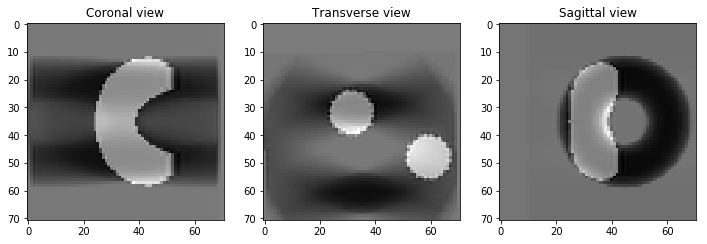

In [49]:
plot_volume(f2 - f2_rec_iter)